<a href="https://colab.research.google.com/github/ninetales2002/Portfolio/blob/main/Optimizing_Debt_Recovery_Strategies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimizing Debt Recovery Strategies
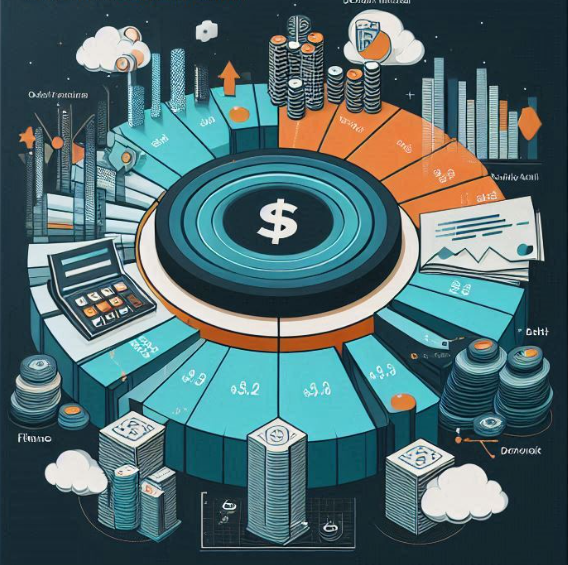

After a debt has been legally declared "uncollectable" by the bank, the account is considered "charged-off." However, this does not mean that the bank abandons efforts to recover the debt. The bank will evaluate the account to determine the expected recovery amount, which represents the potential sum that may be collected from the customer in the future. This amount is a function of the probability of the customer making payments, the total debt, and other factors that impact the ability and willingness to pay.

 The goal for the data scientist is to determine in this non-random assignment whether the incremental amount the bank earns exceeded the additional cost of assigning customers to a higher recovery strategy.

## 1. Regression discontinuity: banking recovery

The bank has implemented different recovery strategies at different thresholds (\$1000, \$2000, etc.) where the greater the expected recovery amount, the more effort the bank puts into contacting the customer. For low recovery amounts (Level 0), the bank just adds the customer's contact information to their automatic dialer and emailing system. For higher recovery strategies, the bank incurs more costs as they leverage human resources in more efforts to obtain payments. Each additional level of recovery strategy requires an additional \$50 per customer so that customers in the Recovery Strategy Level 1 cost the company \$50 more than those in Level 0. Customers in Level 2 cost $50 more than those in Level 1, etc.

The big question: does the extra amount that is recovered at the higher strategy level exceed the extra `$50` in costs? In other words, was there a discontinuity ( a "jump") of more than `$50` in the amount recovered at the higher strategy level?

First, we'll load the banking dataset and look at the first few rows of data in order to understand the dataset itself and begin thinking about how to analyze the data.

In [ ]:
# Import modules
import pandas as pd

# Read in dataset
data = pd.read_csv("bank_data.csv")

# Print the first few rows of the DataFrame
data.head()

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,2030,194,263.540,Level 0 Recovery,19,Male
1,1150,486,416.090,Level 0 Recovery,25,Female
2,380,527,429.350,Level 0 Recovery,27,Male
3,1838,536,296.990,Level 0 Recovery,25,Male
4,1995,541,346.385,Level 0 Recovery,34,Male


## 2. Graphical exploratory data analysis
The bank has implemented different recovery strategies at different thresholds (\$1000, \$2000, \$3000 and \$5000) where the greater the Expected Recovery Amount, the more effort the bank puts into contacting the customer.

 In this step, we are focusing on the first transition between Level 0 and Level 1, which involves customers with Expected Recovery Amounts between \$0 and \$2000. The key transition occurs at the \$1000 threshold:

- Level 0: Expected recovery amounts > \$0 and ≤ $1000
- Level 1: Expected recovery amounts > \$1000 and ≤ \$2000


By examining this transition, we aim to understand if there are other factors, such as customer age, that systematically vary at this threshold. This analysis helps in identifying whether the Expected Recovery Amounts are influenced by factors other than just the recovery amount itself. For instance, if customer age shows a significant jump at the \$1000 threshold, it may indicate that age is a factor affecting the Expected Recovery Amount and the recovery strategy.


This is important because we want to be able to conclude that differences in the actual recovery amount are due to the higher Recovery Strategy and not due to some other difference like age or sex.

To investigate this, we will create a scatter plot of Age vs. Expected Recovery Amount within the range of \$0 to \$2000. This plot will help visualize any potential discontinuities or trends in customer age around the \$1000 threshold.


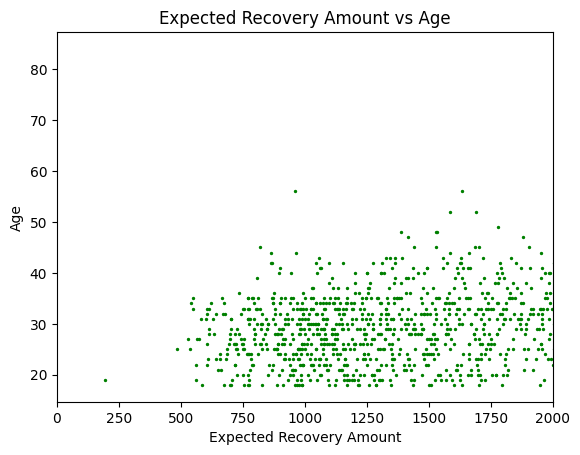

In [ ]:
# Scatter plot of Age vs. Expected Recovery Amount
import matplotlib.pyplot as plt

plt.scatter(x=data['expected_recovery_amount'], y=data['age'], c="g", s=2)
plt.xlim(0, 2000)
#plt.ylim(0, 60)
plt.xlabel("Expected Recovery Amount")
plt.ylabel("Age")
plt.title("Expected Recovery Amount vs Age")

plt.show()

## 3. Statistical test:  age vs. expected recovery amount

The scatter plot did not reveal any obvious discontinuities, so we turn to statistical analysis for a more rigorous examination.

We'll examinate the average age of the customers just above and just below the threshold. Let's start by exploring the range from \$900 to \$1100.
For determining if there are statistically significant differences in median ages just above and just below the threshold, we will use the Kruskal-Wallis test.

The Kruskal-Wallis test is a test used to compare the median of a continuous variable across two or more independent groups. This test is non-parametric, meaning it does not assume that the data follows a specific distribution (e.g., normal distribution). This is particularly useful because age data might not be normally distributed and using a test that doesn't require this assumption ensures more robust results.

To apply the Kruskal-Wallis test to our data we'll define the Groups:

- Group 1: Customers with Expected Recovery Amounts between $900 and \$1000.
- Group 2: Customers with Expected Recovery Amounts between \$1001 and \$2000.


And the following null and alternative Hypothesis

- Null Hypothesis (H_0):
  There is no significant difference in the average age of customers in group 1 and group 2.

- Alternative Hypothesis (H_1):
There is a significant difference in the average age of customers in group 1 and group 2.


We'll define a significance level of 0.05. This means the maximum probability of type I error admitted is %5.00.


In [ ]:
# Import stats module
from scipy import stats

# Compute average age just below and above the threshold
exp_rec_am_900_1100 = data[(900 <= data["expected_recovery_amount"]) & (data["expected_recovery_amount"] <= 1100)]

Level_0_Age = exp_rec_am_900_1100[exp_rec_am_900_1100["recovery_strategy"]== "Level 0 Recovery"]["age"]
Level_1_Age = exp_rec_am_900_1100[exp_rec_am_900_1100["recovery_strategy"]== "Level 1 Recovery"]["age"]


# Perform Kruskal-Wallis test
statistic, p_value = stats.kruskal(Level_0_Age,Level_1_Age)

print(f"Kruskal-Wallis H-statistic: {statistic}")
print(f"P-value: {p_value}")

# Interpret the result
if p_value < 0.05:
    print("Significant difference in ages between the two groups.")
else:
    print("No significant difference in ages between the two groups.")

Kruskal-Wallis H-statistic: 3.1513987711538896
P-value: 0.07586190694799404
No significant difference in ages between the two groups.


The p-value obtained is 0.076 (> 0.05) , which means there's no sufficient evidence to reject the null hypothesis. This means, there's no significance difference between the two groups.

## 4. Statistical test:  sex vs. expected recovery amount
We have seen that there is no major jump in the average customer age just above and just below the $1000 threshold by doing a statistical test as well as exploring it graphically with a scatter plot.  

We want to also test that the percentage of customers that are male does not jump across the \$1000 threshold. We can start by exploring the range of \$900 to \$1100 and later adjust this range.

We can examine this question statistically by developing cross-tabs as well as performing chi-square tests of the percentage of customers that are male vs. female.

The chi-square test for independence is a statistical test used to determine if there is a significant association between two categorical variables. In this case, the test is used to assess whether there is a relationship between the categorical variables "sex" and "recovery_strategy.".  

If the variables are independent, the p-value is not likely to be statistically significant while if they are dependent, the p-value is more likely to be significant (for example, less than 0.01).

Let's set a significance level of 0.01.

In [ ]:
# Number of customers in each category
crosstab = pd.crosstab(exp_rec_am_900_1100['recovery_strategy'], exp_rec_am_900_1100['sex'])
print("Crosstab: \n", crosstab)

# Chi-square test
chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosstab)
print("\np-value: \n", p_val)


Crosstab: 
 sex                Female  Male
recovery_strategy              
Level 0 Recovery       32    57
Level 1 Recovery       40    55

p-value: 
 0.48198988397369014


The obtained p-value is 0.48, which is greater than the significance level of 0.01. Consequently, there is insufficient evidence to reject the null hypothesis, suggesting that there is no significant association between the variables (the variables are independent).

## 5. Exploratory graphical analysis: recovery amount

We are now reasonably confident that customers just above and just below the $1000 threshold are, on average, similar in their average age and gender compositions.  

It is now time to focus on the key outcome of interest, the actual recovery amount. The primary interest lies in understanding the relationship between the expected recovery amount and the actual recovery amount.

A first step in examining the relationship between the actual recovery amount and the expected recovery amount is to develop a scatter plot focused in the range just below and just above the \$1000 threshold.

A jump or discontinuity in the relationship between expected and actual recovery amounts around the $1000 threshold could indicate a significant change in customer behavior, this is, could indicate the existence of Threshold Effects. For example, a shift in risk profile for borrowers.

For this purpose, we will develop a scatter plot of  Expected Recovery Amount (X) versus Actual Recovery Amount (Y) for Expected Recovery Amounts between \$900 to \$1100.  This range covers Levels 0 and 1.  A key question is whether or not we see a discontinuity (jump) around the \$1000 threshold.



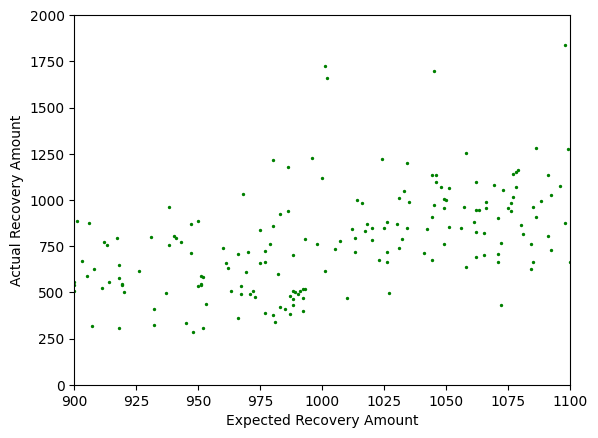

In [ ]:
# Scatter plot of Actual Recovery Amount vs. Expected Recovery Amount

plt.scatter(x= exp_rec_am_900_1100['expected_recovery_amount'], y= exp_rec_am_900_1100['actual_recovery_amount'], c="g", s=2)
plt.xlim(900, 1100)
plt.ylim(0, 2000)
plt.xlabel("Expected Recovery Amount")
plt.ylabel("Actual Recovery Amount")
plt.show()


A we can see, there is no clear discontinuity or jump in the relationship around the \$1000 threshold.
In other words, customers with expected recovery amounts slightly above \$1000 are not behaving differently from customers with expected recovery amounts slightly below $1000 in terms of their actual recovery rates.

## 6. Statistical analysis:  recovery amount
As we did with age, we can perform statistical tests to see if the actual recovery amount has a discontinuity above the $1000 threshold. We are going to do this for two different windows of the expected recovery amount \$900 to \$1100 and for a narrow range of \$950 to \$1050 to see if our results are consistent.

Again, we will use the Kruskal-Wallis test.

We will first compute the average actual recovery amount for those customers just below and just above the threshold using a range from \$900 to \$1100.  Then we will perform a Kruskal-Wallis test to see if the actual recovery amounts are different just above and just below the threshold.  Once we do that, we will repeat these steps for a smaller window of \$950 to \$1050.

In [ ]:
def results(statistic, p_value, alpha):
  print(f"Kruskal-Wallis H-statistic: {statistic}")
  print(f"P-value: {p_value}")

  # Interpret the result
  if p_value < alpha:
      print("Significant difference in expected and recovery amount between the two groups of recovery strategy.")
  else:
      print("No significant difference in expected and recovery amount between the two groups of recovery strategy.")

In [ ]:
# Compute average actual recovery amount just below and above the threshold
#by_recovery_strategy['actual_recovery_amount'].describe().unstack()

# Perform Kruskal-Wallis test
Level_0_actual = exp_rec_am_900_1100[exp_rec_am_900_1100["recovery_strategy"]== "Level 0 Recovery"]["actual_recovery_amount"]
Level_1_actual = exp_rec_am_900_1100[exp_rec_am_900_1100["recovery_strategy"]== "Level 1 Recovery"]['actual_recovery_amount']

statistic1, p_value1 = stats.kruskal(Level_0_actual, Level_1_actual)

print("Test 1: range from 900 to 1100 \n")
results(statistic1, p_value1, 0.05)

# Repeat for a smaller range of $950 to $1050
exp_rec_am_950_1050 = data[(data['expected_recovery_amount']< 1050) & (data['expected_recovery_amount']>= 950)]
Level_0_actual = exp_rec_am_950_1050[exp_rec_am_950_1050["recovery_strategy"]== "Level 0 Recovery"]["actual_recovery_amount"]
Level_1_actual = exp_rec_am_950_1050[exp_rec_am_950_1050["recovery_strategy"]== "Level 1 Recovery"]['actual_recovery_amount']

statistic2, p_value2 = stats.kruskal(Level_0_actual, Level_1_actual)

print("\nTest 2: range from 950 to 1050 \n")
results(statistic2, p_value2, 0.05)

Test 1: range from 900 to 1100 

Kruskal-Wallis H-statistic: 64.89840778685254
P-value: 7.886077128395961e-16
Significant difference in expected and recovery amount between the two groups of recovery strategy.

Test 2: range from 950 to 1050 

Kruskal-Wallis H-statistic: 30.246000000000038
P-value: 3.80575314300276e-08
Significant difference in expected and recovery amount between the two groups of recovery strategy.


## 7. Regression modeling: no threshold
<p>We now want to take a regression-based approach to estimate the program impact at the \$1000 threshold using data that is just above and below the threshold. </p>
<p>We will build two models. The first model does not have a threshold while the second will include a threshold.</p>
<p>The first model predicts the actual recovery amount (dependent variable) as a function of the expected recovery amount (independent variable). We expect that there will be a strong positive relationship between these two variables.  </p>
<p>We will examine the adjusted R-squared to see the percent of variance explained by the model.  In this model, we are not representing the threshold but simply seeing how the variable used for assigning the customers (expected recovery amount) relates to the outcome variable (actual recovery amount).</p>

In [ ]:
X_train = pd.DataFrame(exp_rec_am_900_1100['expected_recovery_amount'])  # X_train must be a 2D array
y_train = exp_rec_am_900_1100['actual_recovery_amount']

# Import statsmodels
import statsmodels.api as sm

# Add a constant term to the predictor variable
X_train = sm.add_constant(X_train)

# Create and fit Ordinary Least Squares (OLS) regression model from the statsmodels library.
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model
print(model.summary())



                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.253
Model:                                OLS   Adj. R-squared:                  0.248
Method:                     Least Squares   F-statistic:                     61.48
Date:                    Sat, 08 Jun 2024   Prob (F-statistic):           3.65e-13
Time:                            15:28:38   Log-Likelihood:                -1286.5
No. Observations:                     184   AIC:                             2577.
Df Residuals:                         182   BIC:                             2583.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

From the provided OLS regression results, we can make the following observations:

1.  **R-squared and Adjusted R-squared**: The R-squared value, which measures the proportion of variance in the dependent variable explained by the independent variables, is 0.253. This indicates that approximately 25.3% of the variability in the actual recovery amount can be explained by the linear relationship with the expected recovery amount. The adjusted R-squared, which accounts for the number of predictors in the model, is slightly lower at 0.248.

2. **Significance of the Model**: The F-statistic tests the overall significance of the model. With a high F-statistic of 61.48 and a very low associated p-value (Prob (F-statistic) < 0.05), we can conclude that the model as a whole is statistically significant.

3. **Coefficients**:

  - The coefficient for the constant term (intercept) is -1918.4549, indicating that when the expected recovery amount is zero, the predicted actual recovery amount is approximately -1918.4549.
  - The coefficient for the expected recovery amount is 2.6956. This means that, on average, for each unit increase in the expected recovery amount, the predicted actual recovery amount increases by 2.6956 units.

4. **Statistical Significance of Coefficients**:

  Both the constant term and the coefficient for the expected recovery amount have p-values less than 0.05, indicating that they are statistically significant predictors of the actual recovery amount.

5. **Other Statistics**: Additional statistics provided include the standard errors of the coefficients, t-values, confidence intervals, and various diagnostic statistics such as the Omnibus, Durbin-Watson, and Jarque-Bera tests.

Overall, the model appears to be statistically significant, and the coefficient for the expected recovery amount is statistically significant, suggesting that it has a significant impact on predicting the actual recovery amount.

## 8. Regression modeling: adding true threshold
<p>From the first model, we see that the expected recovery amount's regression coefficient is statistically significant. </p>
<p>The second model adds an indicator of the true threshold to the model (in this case at \$1000).  </p>
<p>We will create an indicator variable (either a 0 or a 1) that represents whether or not the expected recovery amount was greater than \$1000. When we add the true threshold to the model, the regression coefficient for the true threshold represents the additional amount recovered due to the higher recovery strategy.  That is to say, the regression coefficient for the true threshold measures the size of the discontinuity for customers just above and just below the threshold.</p>
<p>If the higher recovery strategy helped recovery more money, then the regression coefficient of the true threshold will be greater than zero.  If the higher recovery strategy did not help recovery more money, then the regression coefficient will not be statistically significant.</p>

In [ ]:
import numpy as np

# Create indicator (0 or 1) for expected recovery amount >= $1000
data['indicator_1000'] = np.where(data['expected_recovery_amount']<1000, 0, 1)
exp_rec_am_900_1100 = data[(data['expected_recovery_amount']<1100) & (data['expected_recovery_amount']>=900)]

# Define X and y
X = exp_rec_am_900_1100[['expected_recovery_amount', 'indicator_1000']]
y = exp_rec_am_900_1100['actual_recovery_amount']
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y,X).fit()

# Print the model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.314
Model:                                OLS   Adj. R-squared:                  0.307
Method:                     Least Squares   F-statistic:                     41.22
Date:                    Sat, 08 Jun 2024   Prob (F-statistic):           1.83e-15
Time:                            15:46:10   Log-Likelihood:                -1272.0
No. Observations:                     183   AIC:                             2550.
Df Residuals:                         180   BIC:                             2560.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        3.3440    626.274      0.005      0.996   -1232.440    1239.128
expected_recovery_amount     0.6430      0.655      0.981      0.328      -0.650       1.936
indicator_1000             277.6344     74.043      3.750      0.000     131.530     423.739
==============================================================================
Omnibus:                       65.977   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              186.537
Skew:                           1.510   Prob(JB):                     3.12e-41
Kurtosis:                       6.917   Cond. No.                     3.37e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Interpretation:

The coefficient for the "indicator_1000" variable is 277.6344. This coefficient represents the estimated impact of crossing the $1000 threshold on the actual recovery amount.

The associated p-value for this coefficient is less than 0.05 (P>|t| < 0.05), indicating that it is statistically significant

Therefore, the conclusion is that crossing the \$1000 threshold has a statistically significant impact on the actual recovery amount, with an estimated increase of approximately $278.

## 9. Regression modeling: adjusting the window
The regression coefficient for the true threshold was statistically significant with an estimated impact of around \$278.  This is much larger than the \$50 per customer needed to run this higher recovery strategy.

Before sharing these results, we want to confirm that this outcome wasn't due to choosing an expected recovery amount window of \$900 to \$1100. Let's repeat this analysis for the window from \$950 to \$1050 to see if we get similar results.


In [ ]:
# Redefine era_950_1050 so the indicator variable is included
exp_rec_am_950_1050 = data[(data['expected_recovery_amount']<1050) & (data['expected_recovery_amount']>=950)]

# Define X and y
X = exp_rec_am_950_1050[['expected_recovery_amount', 'indicator_1000']]
y = exp_rec_am_950_1050['actual_recovery_amount']
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y,X).fit()

# Print the model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.283
Model:                                OLS   Adj. R-squared:                  0.269
Method:                     Least Squares   F-statistic:                     18.99
Date:                    Sat, 08 Jun 2024   Prob (F-statistic):           1.12e-07
Time:                            15:50:12   Log-Likelihood:                -692.92
No. Observations:                      99   AIC:                             1392.
Df Residuals:                          96   BIC:                             1400.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     -279.5243   1840.707     -0.152      0.880   -3933.298    3374.250
expected_recovery_amount     0.9189      1.886      0.487      0.627      -2.825       4.663
indicator_1000             286.5337    111.352      2.573      0.012      65.502     507.566
==============================================================================
Omnibus:                       39.302   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.258
Skew:                           1.564   Prob(JB):                     1.37e-18
Kurtosis:                       6.186   Cond. No.                     6.81e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The answer? Whether we use a wide (\$900 to \$1100) or narrower window (\$950 to \$1050), the incremental recovery amount at the higher recovery strategy is much greater than the \$50 per customer it costs for the higher recovery strategy.  So we conclude that the higher recovery strategy is worth the extra cost of \$50 per customer.